In [1]:
# Install a conda package in the current Jupyter kernel
import sys

import string
import gensim
from gensim import corpora, models
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

import warnings
warnings.filterwarnings('ignore')

# We import sklearn.
import sklearn

import csv
import gc
import pandas as pd
import random
import pickle

csv.field_size_limit(sys.maxsize)

In [2]:
def uniquify(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

In [3]:
from datetime import timedelta, date

years = [7,10,11,12,13,14,15,16]


def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)


dates = {}        
for year in years:
    days = []
    year = year + 2000
    start = date(year, 1, 1)
    end = date(year, 12, 31)
    for dt in daterange(start, end):
        days.append(dt.strftime("%m-%d-%Y"))
    dates[year] = days

In [4]:
docs = []
years = [2007,2010,2011,2012,2013,2014,2015,2016]
BGT_jobID_50 = []

a = 0
for year in years:
    for date in dates[year]:
        a += 1
        date_docs = []
        filename = '../../text_data/JobText_US_' + date + '.txt'
        with open(filename, encoding='latin-1') as file:
            i = 0 
            nums = random.sample(range(1, 10000), 500)
            for line in csv.reader(file, dialect="excel-tab"):
                i += 1
                if line[0] != '' and i in nums:
                    BGT_jobID_50.append(line[1])
                    docs.append(line[3])

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
# stemmer
p_stemmer = PorterStemmer()

In [7]:
documents = []

for i in docs:
    # tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = [x.lower() for x in tokenizer.tokenize(i)]

    # remove stop words, numbers, and short words from tokens
    stopped_tokens = [i for i in tokens if not i in stop_words and len(i) > 3 and not i.isdigit()]

    # stem and lemmatize tokens
    stemmed_tokens = [p_stemmer.stem(WordNetLemmatizer().lemmatize(i, pos='v')) for i in stopped_tokens]
    
    # add tokens to list
    documents.append(stemmed_tokens)

In [8]:
len(documents)

1439342

In [11]:
# pickle documents
import pickle 
docfile = open('documents.pkl', 'wb')
pickle.dump(documents, docfile, pickle.HIGHEST_PROTOCOL)

# pickle BGT ID dictionary
idfile = open('bgt_50.pkl', 'wb')
pickle.dump(BGT_jobID_50, idfile, pickle.HIGHEST_PROTOCOL)

In [4]:
# turn tokenize documents into a id - term dictionary
#documents = []
dictionary = corpora.Dictionary(documents)

len(dictionary)

0

In [ ]:
# filter out words that are too frequent or too infrequent
dictionary.filter_extremes(no_below=0.02, no_above=0.5, keep_n=100000)
dictionary.save('dictionary_500')
len(dictionary)

In [ ]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(document) for document in documents]
corpora.MmCorpus.serialize('corpus_500.mm', corpus)

In [5]:
# load dictionary, corpus, documents, and IDs
dictionary = dictionary.load('dictionary_500')
corpus = corpora.MmCorpus('corpus_500.mm')

docfile = open('documents.pkl', 'rb')
documents = pickle.load(docfile)

idfile = open('bgt_500.pkl', 'rb')
BGT_jobID_50 = pickle.load(idfile)

In [6]:
# creating object for LDA model
Lda = gensim.models.ldamodel.LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word=dictionary, chunksize=50000, update_every=1, passes=4)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

In [6]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=10, limit=71, step=5)

10
15
20
25
30
35
40
45
50
55
60
65
70


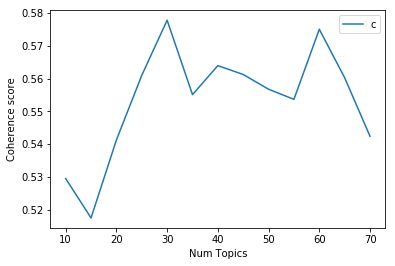

In [47]:
# Show graph
import matplotlib.pyplot as plt

limit=71; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, list(values_1)+list(values_2)+list(values_3)+list(values_4)+list(values_5))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
for m, cv in zip(x, list(values_1)+list(values_2)+list(values_3)+list(values_4)+list(values_5)):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5295
Num Topics = 15  has Coherence Value of 0.5174
Num Topics = 20  has Coherence Value of 0.5412
Num Topics = 25  has Coherence Value of 0.561
Num Topics = 30  has Coherence Value of 0.5778
Num Topics = 35  has Coherence Value of 0.5551
Num Topics = 40  has Coherence Value of 0.564
Num Topics = 45  has Coherence Value of 0.5613
Num Topics = 50  has Coherence Value of 0.5567
Num Topics = 55  has Coherence Value of 0.5537
Num Topics = 60  has Coherence Value of 0.5751
Num Topics = 65  has Coherence Value of 0.5603
Num Topics = 70  has Coherence Value of 0.5424


In [49]:
optimal_model = Lda(corpus, num_topics=30, id2word=dictionary, chunksize=50000, update_every=1, passes=4)        
optimal_model.save("lda_model_500")

In [7]:
optimal_model = Lda.load("lda_model_500")
dictionary = dictionary.load('dictionary_500')
corpus = corpora.MmCorpus('corpus_500.mm')
num_topics = 30

In [10]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
29     -66.093872    6.981722       1        1  8.912036
28    -101.918602   35.309967       2        1  7.426929
10     102.350777  -45.307182       3        1  6.425927
12     -29.182251 -101.143929       4        1  5.131665
21     -64.233604   89.795616       5        1  4.767157
23      69.868141  -79.468643       6        1  4.533102
18     -68.297134  -34.253136       7        1  4.515435
6      -33.278717  -14.404220       8        1  4.190481
13      93.048607   53.595078       9        1  4.178124
19       5.805738   43.356030      10        1  4.057817
7       59.617023   95.487526      11        1  3.629708
27      17.581059   82.305374      12        1  3.374418
22      -0.723460    4.011202      13        1  3.282631
4       31.706289  -16.563320      14        1  3.130013
1       67.774498  -24.400660      15        1  3.114382
3      -29.525579   25.556162      16        1  3.010013
16      27.885643 -104.304764      17        1  2.993879
25      -0.596626  -33.796181      18        1  2.639387
11       2.471579  -71.781258      19        1  2.612947
24     -74.640701  -76.667473      20        1  2.412311
2      -24.289551   66.901443      21        1  2.366230
5       37.823639  -54.223701      22        1  2.352573
0      109.211235    3.998327      23        1  1.904740
17     -34.203430  -55.476345      24        1  1.857152
14      32.874348   19.071169      25        1  1.847512
20     -61.370605   47.701366      26        1  1.496051
15     -14.757085  110.229614      27        1  1.390249
9       69.527603   15.787944      28        1  0.948488
8     -106.118523  -16.345806      29        1  0.814376
26      48.348534   53.559742      30        1  0.684264, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
1374   Default  1.500737e+06         sale  1.500737e+06  30.0000  30.0000
18     Default  2.124247e+06       custom  2.124247e+06  29.0000  29.0000
38     Default  9.125760e+05          job  9.125760e+05  28.0000  28.0000
10     Default  1.072560e+06         care  1.072560e+06  27.0000  27.0000
181    Default  7.194300e+05      patient  7.194300e+05  26.0000  26.0000
44     Default  7.569560e+05         nurs  7.569560e+05  25.0000  25.0000
394    Default  7.993950e+05        engin  7.993950e+05  24.0000  24.0000
295    Default  1.772682e+06      develop  1.772682e+06  23.0000  23.0000
24     Default  1.659532e+06       employ  1.659532e+06  22.0000  22.0000
431    Default  1.125462e+06      account  1.125462e+06  21.0000  21.0000
527    Default  8.346060e+05       market  8.346060e+05  20.0000  20.0000
695    Default  5.548260e+05        store  5.548260e+05  19.0000  19.0000
186    Default  9.711880e+05        pleas  9.711880e+05  18.0000  18.0000
131    Default  1.082376e+06      contact  1.082376e+06  17.0000  17.0000
419    Default  1.430870e+06      product  1.430870e+06  16.0000  16.0000
600    Default  1.643973e+06       applic  1.643973e+06  15.0000  15.0000
296    Default  4.470650e+05       driver  4.470650e+05  14.0000  14.0000
51     Default  1.259270e+06         post  1.259270e+06  13.0000  13.0000
139    Default  8.500820e+05        email  8.500820e+05  12.0000  12.0000
214    Default  1.171656e+06       system  1.171656e+06  11.0000  11.0000
278    Default  1.485572e+06        appli  1.485572e+06  10.0000  10.0000
31     Default  7.821290e+05       health  7.821290e+05   9.0000   9.0000
40     Default  6.835400e+05        medic  6.835400e+05   8.0000   8.0000
146    Default  4.901960e+05      financi  4.901960e+05   7.0000   7.0000
554    Default  9.756000e+05      project  9.756000e+05   6.0000   6.0000
810    Default  4.785730e+05      specifi  4.785730e+05   5.0000   5.0000
175    Default  1.210539e+06     opportun  1.210539e+06   4.0

In [8]:
optimal_model.show_topics(num_topics=30)

[(0,
  '0.058*"driver" + 0.037*"truck" + 0.020*"drive" + 0.015*"transport" + 0.013*"class" + 0.012*"home" + 0.011*"warehous" + 0.010*"mile" + 0.009*"deliveri" + 0.009*"call"'),
 (1,
  '0.039*"system" + 0.027*"secur" + 0.026*"support" + 0.024*"network" + 0.021*"technolog" + 0.017*"technic" + 0.016*"engin" + 0.012*"softwar" + 0.011*"inform" + 0.011*"oper"'),
 (2,
  '0.027*"nurs" + 0.024*"healthcar" + 0.022*"travel" + 0.017*"medic" + 0.015*"care" + 0.013*"health" + 0.012*"therapist" + 0.011*"physician" + 0.011*"hospit" + 0.011*"pharmaci"'),
 (3,
  '0.040*"specifi" + 0.039*"appli" + 0.032*"careerbuild" + 0.027*"email" + 0.026*"websit" + 0.024*"snapshot" + 0.022*"agre" + 0.022*"type" + 0.021*"inform" + 0.019*"compli"'),
 (4,
  '0.048*"account" + 0.035*"financi" + 0.022*"bank" + 0.020*"financ" + 0.013*"client" + 0.011*"opportun" + 0.009*"half" + 0.009*"loan" + 0.009*"robert" + 0.009*"branch"'),
 (5,
  '0.027*"must" + 0.021*"technician" + 0.017*"hour" + 0.017*"vehicl" + 0.016*"repair" + 0.016

In [ ]:
topics = {}
vectors = []
for i,idx in enumerate(documents):
        # get the topic percentages for each document
        bow = dictionary.doc2bow(idx)
        v = optimal_model.get_document_topics(bow)
        
        # key => value, document number => topic vector
        topics[i] = v
        
        # iterate through the topic vector
        dict = {}
        for j,jdx in enumerate(v):
            # key => value, topic number => percentage of document
            dict[jdx[0]] = jdx[1]

        # give the dictionary the same number of keys as topics, one for each topic
        vector = []
        for k in range(num_topics):
            # if the topic was in the original vector, use the given percentage
            if k in dict.keys():
                vector.append(dict[k])
            # else give the topic the percentage zero
            else:
                vector.append(0)
        # add the vector to the set of document vectors
        vectors.append(np.asarray([vector]))

In [ ]:
# pickle vectors
vecfile = open('vectors_500.pkl', 'wb')
pickle.dump(vectors, vecfile, pickle.HIGHEST_PROTOCOL)

In [14]:
vecfile = open('vectors_500.pkl', 'rb')
vectors = pickle.load(vecfile)

In [5]:
years = ['07', '11', '12', '13', '14', '15', '16']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
titles = {}

"""Main"""
for year in years:
    for month in months:
        filename = '../Main Text Files/M2ain 20' + year +'/Main 20' + year + '-'+ month +'.txt'
        with open(filename, encoding='latin-1') as file:
            for line in csv.reader(file, dialect="excel-tab"):
                if line[0] in BGT_jobID_50:
                    titles[line[0]] = line[3]

In [ ]:
# pickle titles
docfile = open('titles_7_500.pkl', 'wb')
pickle.dump(titles, docfile, pickle.HIGHEST_PROTOCOL)

In [ ]:
titlefile = open('titles_500.pkl', 'rb')
titles = pickle.load(titlefile)

In [1]:
def top_5_similar(vectors):
    # choose five random job postings
    for j in range(5):
        index = np.random.randint(0,len(titles) - 1)
        
        # find cosine similarity and euclidean distance from the given vector for every other job posting
        cosines = {}
        euclideans = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i
                euclideans[sklearn.metrics.pairwise.euclidean_distances(vectors[index],vectors[i])[0][0]] = i

        # find the 5 highest cosine similarity and 5 shortest euclidean distance
        top_5_cosine = sorted(cosines.keys(), reverse=True)[:6]
        top_5_euclidean = sorted(euclideans.keys())[:6]
        
        # print out the cosine similarities
        print("\nTop 5 cosine similarity to:", titles[BGT_jobID_50[index]])
        for i,indx in enumerate(top_5_cosine):
            print("  ", round(top_5_cosine[i], 3), titles[BGT_jobID_50[cosines[top_5_cosine[i]]]])
            
        # print out the euclidean distances
        print("Lowest 5 euclidean distance from:", titles[BGT_jobID_50[index]])
        for k,inx in enumerate(top_5_euclidean):
            print("  ", round(top_5_euclidean[k], 3), titles[BGT_jobID_50[euclideans[top_5_euclidean[k]]]])

In [ ]:
top_5_similar(vectors)

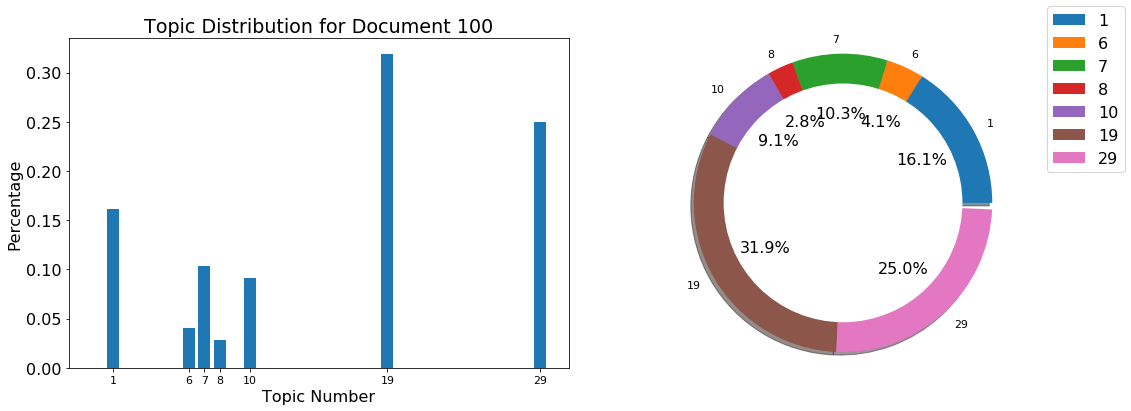

In [20]:
# import matplotlib
import matplotlib.pyplot as plt

doc_num = 100
labels = np.where(vectors[doc_num][0] != 0)[0]
plt.rcParams['figure.figsize'] = (16,6)
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=11)    

topics = np.arange(30)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(range(num_topics), vectors[doc_num][0], align='center')
ax1.set_xticks(labels)
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Topic Number')
ax1.set_title('Topic Distribution for Document ' + str(doc_num))

ax2.pie(vectors[doc_num][0][labels], autopct='%1.1f%%', labels=labels, shadow=True)
plt.legend([topics[i] for i in labels], loc=1, borderaxespad=-2)

#draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [16]:
def top_1000_similar(vectors):
        indices = []
        index = 32535
        cosines = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i

        top_1000_cosine = sorted(cosines.keys(), reverse=True)[:1001]
        print("\nTop 1000 cosine similarity to:", index)
        for i,ind in enumerate(top_1000_cosine):
            print("  ", round(ind, 3), cosines[ind])
            indices.append(cosines[ind])
            
        return indices

indices = top_1000_similar(vectors)


Top 1000 cosine similarity to: 32535
   1.0 22274
   1.0 67183
   1.0 67180
   0.999 67141
   0.999 67179
   0.999 67178
   0.998 67666
   0.998 34848
   0.998 67704
   0.998 67320
   0.998 67318
   0.998 4689
   0.998 67695
   0.997 104344
   0.997 32528
   0.996 67176
   0.996 3753
   0.996 67177
   0.996 3756
   0.996 32531
   0.996 67147
   0.996 32532
   0.996 32720
   0.996 67149
   0.996 32527
   0.996 104345
   0.995 4688
   0.995 34865
   0.995 34851
   0.995 67705
   0.995 67700
   0.995 4684
   0.991 67181
   0.991 67182
   0.991 32529
   0.991 32533
   0.986 67013
   0.985 66854
   0.985 66741
   0.985 66719
   0.985 163071
   0.985 103065
   0.985 66730
   0.985 32242
   0.985 103085
   0.985 163056
   0.985 66722
   0.985 32231
   0.985 163044
   0.985 163944
   0.985 104630
   0.985 66740
   0.984 33668
   0.984 67701
   0.984 67703
   0.977 33605
   0.977 66992
   0.977 163108
   0.976 67205
   0.976 66986
   0.976 104780
   0.975 66980
   0.975 66975
   0.975 33629
  

   0.914 851942
   0.914 847365
   0.914 222949
   0.914 477405
   0.914 434676
   0.914 868704
   0.914 1007592
   0.914 1225250
   0.914 883604
   0.914 1260917
   0.914 309016
   0.914 958518
   0.914 925760
   0.914 844618
   0.914 288721
   0.914 960669
   0.914 1293701
   0.914 815023
   0.914 477856
   0.914 1409050
   0.913 879273
   0.913 1142692
   0.913 915833
   0.913 471598
   0.913 340511
   0.913 1379754
   0.913 1271857
   0.913 507561
   0.913 940895
   0.913 1120220
   0.913 1419346
   0.913 918302
   0.913 866731
   0.913 5593
   0.913 57434
   0.913 865100
   0.913 1096379
   0.913 1407326
   0.913 1379814
   0.913 246693
   0.913 1071659
   0.913 1226391
   0.913 1169178
   0.913 1405233
   0.913 59399
   0.913 1065790
   0.913 968520
   0.913 814817
   0.912 19967
   0.912 582711
   0.912 1172469
   0.912 1271306
   0.912 893241
   0.912 61224
   0.912 358562
   0.912 820371
   0.912 820579
   0.912 1436206
   0.912 1412813
   0.912 591034
   0.912 508822
   0.912